<a href="https://colab.research.google.com/github/romaz21/study/blob/main/Copy_of_hw_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Логистическая регрессия

В этом домашнем задании мы изучим логистическую регрессию.
# Часть 1. Реализация логистической регрессии с регуляризацией
Вам предстоит применить $L_2$-регуляризацию к алгоритму логистической регрессии. На семинарском занятии мы применяли $L_2$-регуляризацию к линейной регрессии, а также реализовали логистическую регрессию. Поэтому все необходимые компоненты у нас уже есть, осталось только их соединить.


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Задание 1. Реализуйте алгоритм логрегрессии с $L_2$-регуляризацией.

Вам необходимо реализовать лишь методы `basic_term`, `regularization_term` и `grad`: остальное мы сделали за вас.

* Метод `basic_term(self, X, y, logits)` вычисляет основное слагаемое градиента логистической функции потерь по формуле с семинара:

$$\nabla_w L = -\frac{1}{\ell}\sum\limits_{i=1}^{\ell}y^i\cdot\left(1 - \frac{1}{1 + \mathrm{exp}(-y^i \cdot \langle w, x^i \rangle)}\right) \cdot x^i = -\frac{1}{\ell}\sum\limits_{i=1}^{\ell}y^i\cdot\left(1 - \sigma(y^i \cdot \langle w, x^i \rangle)\right) \cdot x^i.$$

* Метод `regularization_term(self, weights)` вычисляет градиент регуляризационного слагаемого функции потерь. Само регуляризационное слагаемое имеет вид
$$L_2 (w) = \sum_{j=1}^{n}w_j^2.$$
Производная регуляризационного слагаемого по каждому весу вычисляется по формуле
$$\frac{\partial L_2}{\partial w_1} = 2 \cdot w_1.$$
Таким образом, градиент по вектору весов равен
$$\nabla_{w}L_2 = (0, 2w_1, \ldots, 2w_k)$$
(не учитывая $w_0$).

* метод `grad(self, X, y, logits, weights)` складывает слагаемые с учетом константы регуляризации $C$: $$\nabla_{w}L + C\cdot \nabla_{w}L_2.$$

In [112]:
class MyL2LogisticRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C

    def sigmoid(self, t):
        return 1. / (1 + np.exp(-t))

    def basic_term(self, X, y, logits):
        # Вычисляет градиент логистической функции потерь по весам алгоритма
        # (исключая регуляризационное слагаемое)
        # ВАШ КОД
        #print(y[0])
        #print((1-self.sigmoid(y[0]*logits)))
        grad = -sum([y[i]*X[i]*(1-self.sigmoid(y[i]*logits[i])) for i in range(len(y))])/len(y) #ВАШ КОД. Вычислите слагаемое от логистической функции потерь
        return grad

    def regularization_term(self, weights):
        # Вычисляет регуляризационное слагаемое градиента функции потерь
        # (без домножения на константу регуляриации)
        grad = 2 * weights #ВАШ КОД
        grad[0] = 0
        return grad

    def grad(self, X, y, logits, weights):
        # Принимает на вход X, y, logits и вычисляет градиент логистической
        # функции потерь (включая регуляризационное слагаемое).
        # ВАШ КОД. Вычислите basic_term и regularization_term.
        grad = self.basic_term(X, y, logits) + self.C * self.regularization_term(weights) #ВАШ КОД. Сложите две компоненты (не забудьте домножить на C)
        return grad

    def fit(self, X, y, max_iter=1000, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Множество допустимых классов: {1, -1}
        # Не забудьте про фиктивный признак, равный 1!
        X = np.array(X)
        y = np.array(y)
        y = 2 * y - 1

        # Добавляем признак из единиц
        X = np.hstack([np.ones([X.shape[0], 1]), X])  # [ell, n]

        l, n = X.shape
        # Инициализируем веса
        weights = np.random.randn(n)

        losses = []

        for iter_num in range(max_iter):
            # calculate grad
            logits = (X @ weights.reshape(n, 1)).ravel()  # [ell]
            grad = self.grad(X, y, logits, weights)
            # update weights
            weights -= grad * lr

            # calculate loss
            loss = np.mean(np.log(1 + np.exp(-y * logits))) + self.C * np.sum(weights[1:] ** 2)
            losses.append(loss)

        # assign coef, intersept
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict_proba(self, X):
        # Принимает на вход X и возвращает ответы модели
        X = np.array(X)
        X = np.hstack([np.ones([X.shape[0], 1]), X])  # [ell, n]
        weights = np.concatenate([self.intercept_.reshape([1]), self.coef_])
        logits = (X @ weights.reshape(-1, 1))  # [ell, 1]

        return self.sigmoid(logits)


    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

### Протестируем наш класс
Для этого проверим, что вычисление градиентов правильно работает на каких-то случайных входах.

In [113]:
reg_t

array([0., 2., 4.])

In [114]:
dummy_clf = MyL2LogisticRegression(C=10.)
X = np.arange(6).reshape(2, 3)
y = np.array([0, 1])
weights = np.array([-1., 1., 2])
logits = X @ weights

b_t = dummy_clf.basic_term(X, y, logits)
reg_t = dummy_clf.regularization_term(weights)
grad = dummy_clf.grad(X, y, logits, weights)

b_t, reg_t, grad

(array([-2.50521328e-05, -3.34028437e-05, -4.17535546e-05]),
 array([0., 2., 4.]),
 array([-2.50521328e-05,  1.99999666e+01,  3.99999582e+01]))

In [115]:
assert np.allclose(b_t, [-2.50521328e-05, -3.34028437e-05, -4.17535546e-05])
assert np.allclose(reg_t, [0., 2., 4.])
assert np.allclose(grad, [-2.50521328e-05,  1.99999666e+01,  3.99999582e+01])

Если тесты прошли, можно смело сдавать реализацию на Stepik!

### Проверим на датасете blobs с семинара

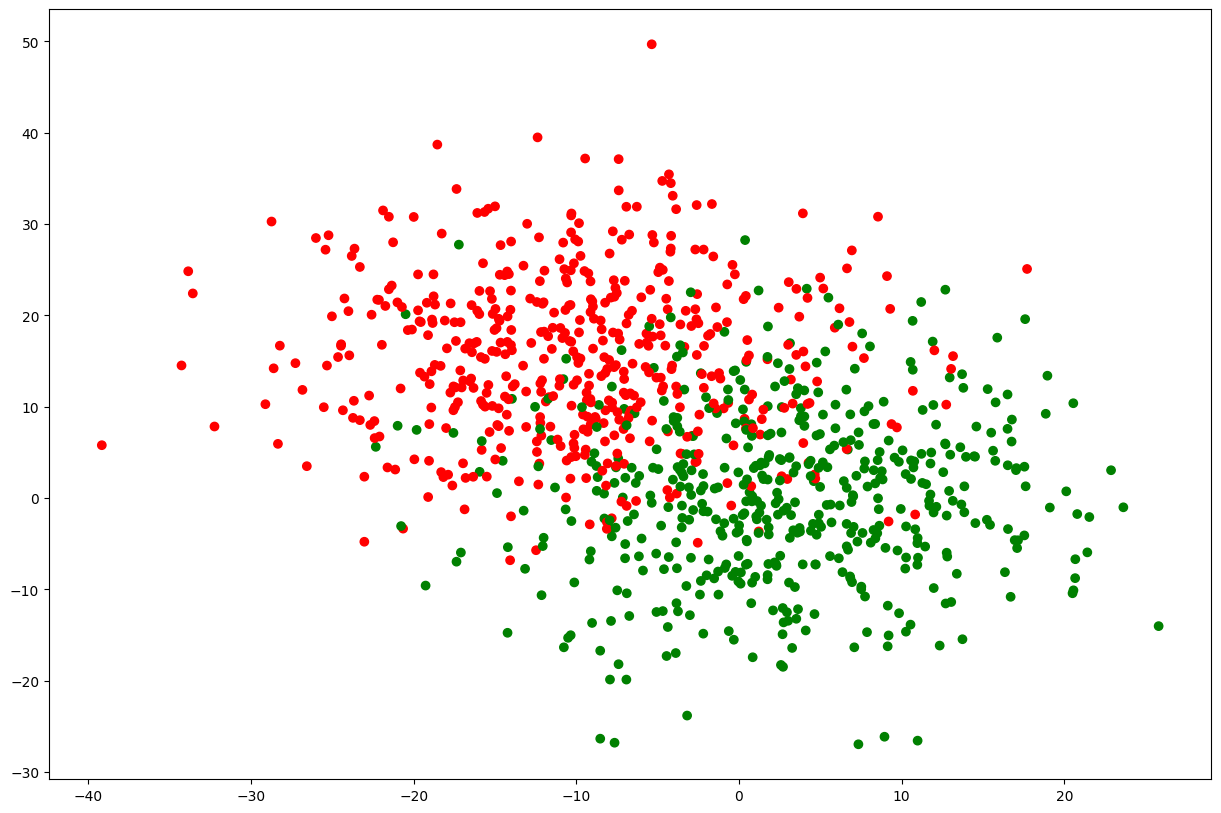

In [116]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-10, 15],[2,-0.5]], cluster_std=9, random_state=42)
# Здесь мы взяли другие центры, чтобы регуляризация имела значимый эффект


colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y == cl] = str(colors[i])

plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

## Задание 2. Применение созданного класса к искусственным данным
Создайте объект класса `MyL2LogisticRegression`, рассмотрев параметр регуляризации $С = 0.01$.

Обучите модель с помощью метода `fit` с параметром `max_iter=1000`. Какие у модели получились веса? Введите полученные веса на Stepik.

**ВАЖНО!!! Если параметр `max_iter` в методе `fit` выбрать другим, то ответ получится другой, и Stepik его не зачтет!**  

In [117]:
# При C=0.01

clf = MyL2LogisticRegression(C=0.01) # ВАШ КОД. Создайте модель

losses = clf.fit (X, y)# ВАШ КОД. Обучите модель

coef, intercept = clf.coef_, clf.intercept_

coef, intercept

(array([ 0.15874444, -0.17700964]), 1.9273408167040516)

Проверим, что лосс падает.

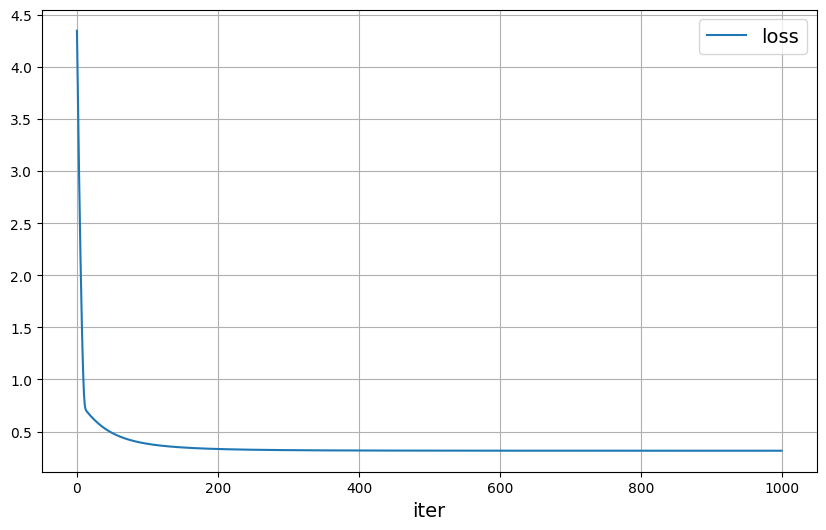

In [118]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

## Задание 3. Какое accuracy дает наша модель на обучающих данных?
Предскажите значения целевой переменной, используя метод predict. Вычислите accuracy. Сдайте полученное значение на Stepik.


In [119]:
from sklearn.metrics import accuracy_score

predictions = clf.predict(X) #ВАШ КОД
score = accuracy_score(y, predictions)#ВАШ КОД
print(f'Model accuracy = {score}')

Model accuracy = 0.861


Визуализируем работу модели.

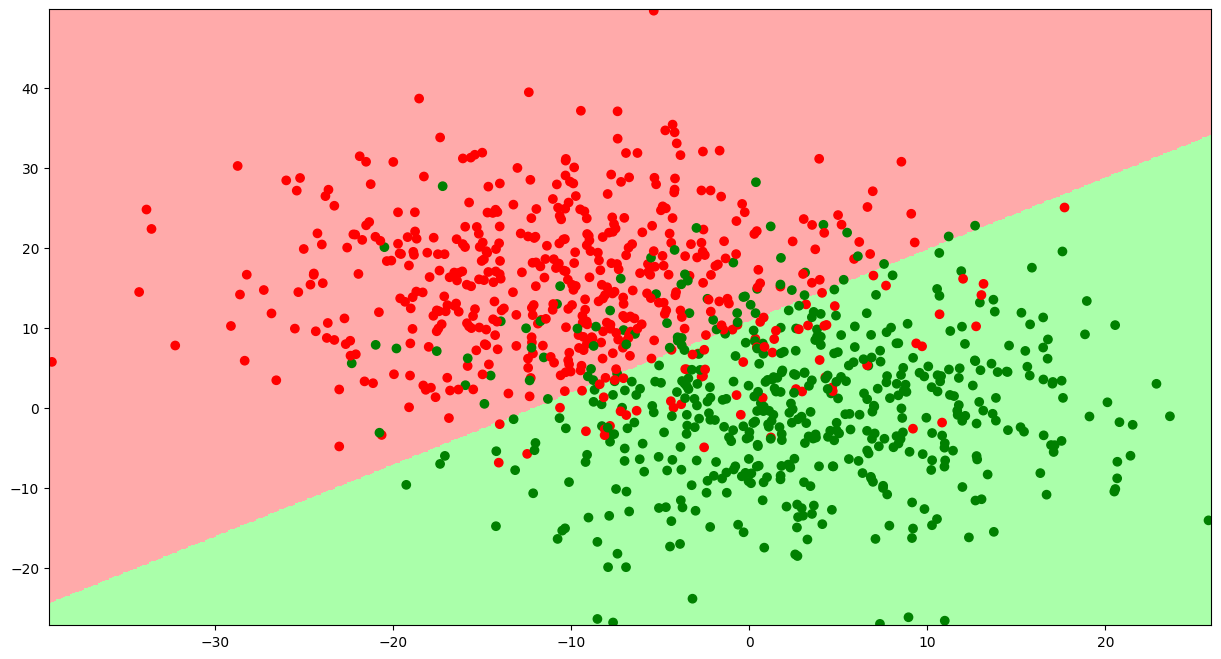

In [120]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

## Задание 4. Качество в зависимости от константы регуляризации
Проделайте процедуру из заданий 2, 3 для константы регуляризации $C=2$ и вычислите accuracy, а также проанализируйте, как отличаются веса моделей и разделяющие поверхности. Постройте графики сходимости функции потерь и попробуйте объяснить полученный эффект. Выберите верные утверждения в задании на Stepik.


In [121]:
# При C=0.01

clf = MyL2LogisticRegression(C=2.) # ВАШ КОД. Создайте модель

losses = clf.fit (X, y)# ВАШ КОД. Обучите модель

coef, intercept = clf.coef_, clf.intercept_

coef, intercept

(array([ 0.16813553, -0.26168883]), 1.3249045248434401)

In [122]:
from sklearn.metrics import accuracy_score

predictions = clf.predict(X) #ВАШ КОД
score = accuracy_score(y, predictions)#ВАШ КОД
print(f'Model accuracy = {score}')

Model accuracy = 0.841


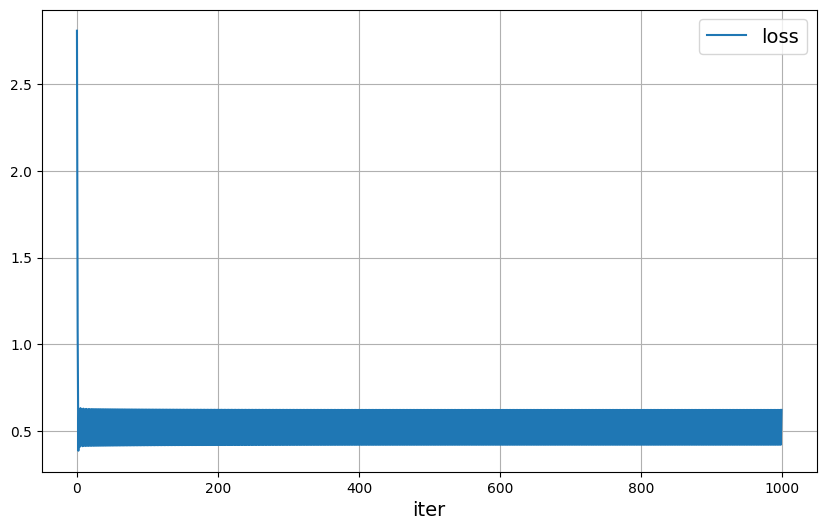

In [123]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

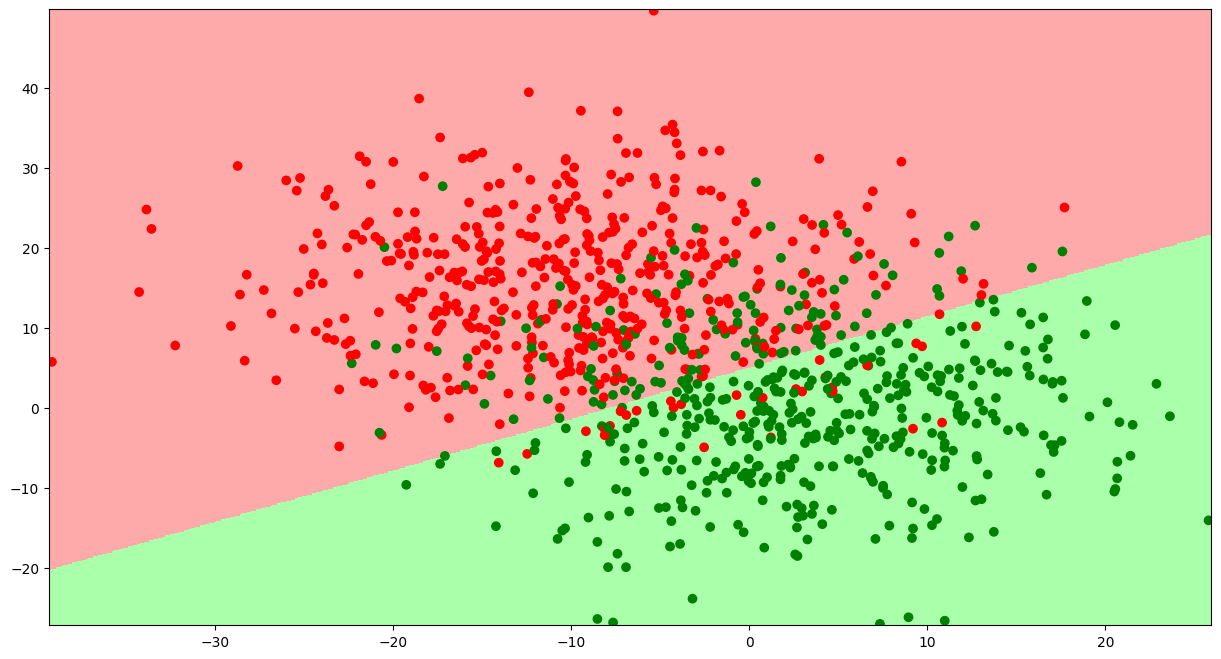

In [124]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 500),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

**БОНУС**. Что будет, если взять константу регуляризации слишком большой, например, $C=100$? Попробуйте обучить такую модель. Объясните полученный эффект. Подумайте, как это можно было бы исправить.

In [125]:
# ВАШ КОД

# Часть 2. Использование логистической регрессии из sklearn
Мы с вами самостоятельно реализовали обучение логистической регрессии. Теперь давайте поработаем с коробочной реализацией логистической регрессии из библиотеки sklearn. Делать мы это будем на том же наборе данных `forest`, с которым мы уже работали в домашнем задании "[Пайплайн машинного обучения](https://colab.research.google.com/drive/1MXMA7Zp2R0RiJ5fUlM9hr2Ww5LBrI4db?usp=sharing#scrollTo=YD0NXyUYKxY7)".

Скачайте набор данных по [ссылке](https://drive.google.com/file/d/1T9jXx2qBUMw03BsB2IdZpThDDfKKmrSK/view?usp=sharing). Загрузим и разобьем данные на обучающее и тестовое множества, как и в предыдущем домашнем задании.

In [126]:
!gdown 1T9jXx2qBUMw03BsB2IdZpThDDfKKmrSK

all_data = pd.read_csv('forest_dataset.csv')
all_data.head()

Downloading...
From: https://drive.google.com/uc?id=1T9jXx2qBUMw03BsB2IdZpThDDfKKmrSK
To: /content/forest_dataset.csv
100% 1.29M/1.29M [00:00<00:00, 44.6MB/s]


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


In [127]:
from sklearn.model_selection import train_test_split

In [128]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(
    feature_matrix, labels, test_size=0.2, random_state=42)

В модели `sklearn.linear_model.LogisticRegression` константа регуляризации $C$ работает иначе, чем у нас:
* Малые значения $C$ соответствуют сильной регуляризации;
* Большие значения $C$ соответствуют слабой регуляризации.

## Задание 5. Исследование регуляризации в sklearn

Для нашего набора данных обучите модель `sklearn.linear_model.LogisticRegression` на `(train_feature_matrix, train_labels)`, перебирая параметр $C$ по сетке, указанной ниже. Можете выполнить перебор вручную или использовать методы `sklearn`.

In [129]:
C_grid = np.logspace(-5, 5, 11)
C_grid

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

Для каждого значения $C$ вычислите `accuracy_score` на обучающем и тестовом множествах. Запишите результаты в массив `train_accuracies` и `test_accuracies`.

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.model import train_test_split

In [145]:
train_accuracies = []
test_accuracies = []
X_train, X_test, y_train, y_test = train_test_split(X, y)
for C in C_grid:
    # ВАШ КОД. Заполните массивы train_accuracies и test_accuracies.
    # ИСПОЛЬЗУЙТЕ LogisticRegression из sklearn, а не вашу имплементацию!
    clf = LogisticRegression(C = C, max_iter=100)
    clf.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(clf.predict(X_train), y_train))
    test_accuracies.append(accuracy_score(clf.predict(X_test), y_test))

Построим график зависимости accuracy от $C$. Сравните кривые качества на обучающем и тестовом множествах. Для какого значения $C$ получилось наилучшее качество на **тестовом множестве**? Ответ сдайте на Stepik.

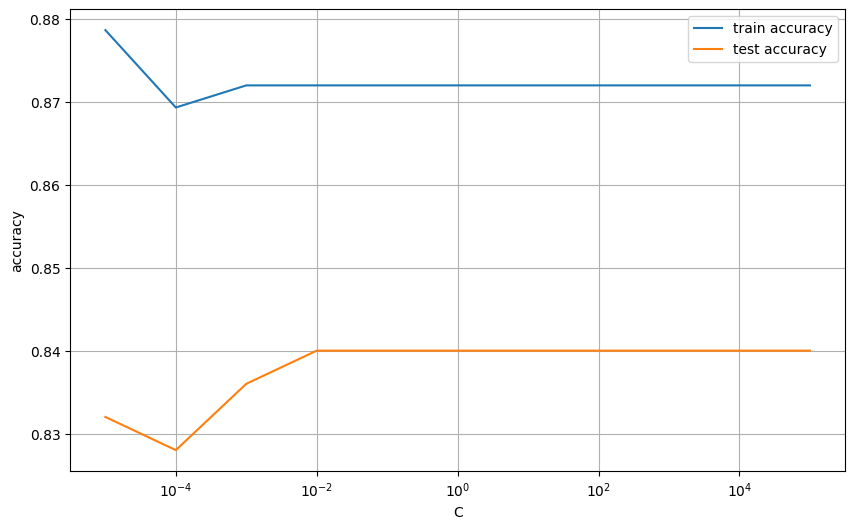

In [146]:
plt.figure(figsize=(10, 6))
plt.plot(C_grid, train_accuracies, label='train accuracy')
plt.plot(C_grid, test_accuracies, label='test accuracy')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()